In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from model import Deeplabv3

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 
n_features = 1 
path_train = 'data/train/'
path_test = 'data/test/'

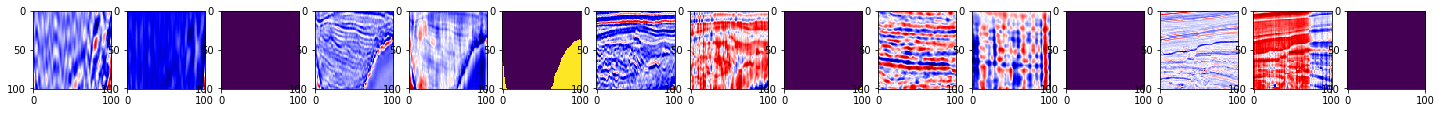

In [3]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(30,15))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('data/train/images/' + img_name + '.png', grayscale=True)
    img_mask = load_img('data/train/masks/' + img_name + '.png', grayscale=True)
    
    img = np.array(img)
    img_cumsum = (np.float32(img)-img.mean()).cumsum(axis=0)
    img_mask = np.array(img_mask)
    
    plt.subplot(1,3*(1+len(ids)),q*3-2)
    plt.imshow(img, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3-1)
    plt.imshow(img_cumsum, cmap='seismic')
    plt.subplot(1,3*(1+len(ids)),q*3)
    plt.imshow(img_mask)
plt.show()

In [4]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train

    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


A Jupyter Widget


Done!


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=2019)

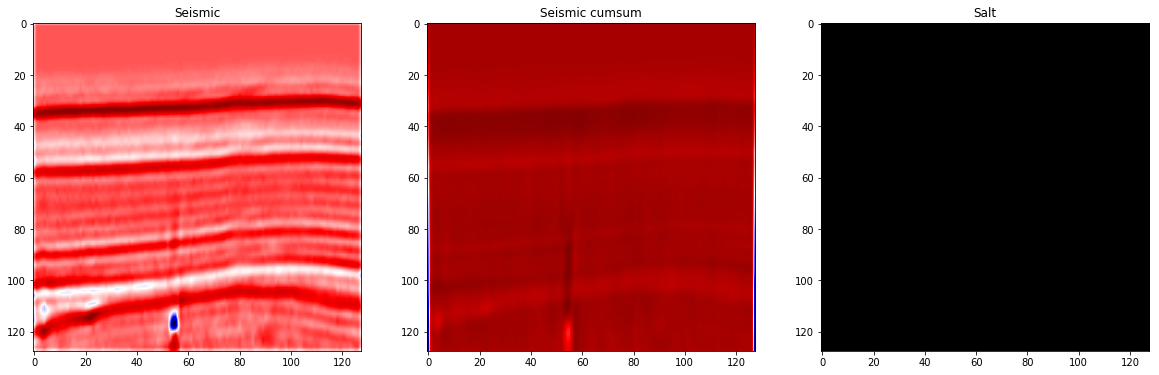

In [7]:
ix = random.randint(0, len(X_train))

has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(X_train[ix, ..., 1], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[1].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[1].set_title('Seismic cumsum')

ax[2].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[2].set_title('Salt');

In [8]:
image_generator = ImageDataGenerator(
                  featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.2, 
                  height_shift_range = 0.2, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

mask_generator = ImageDataGenerator(
                  featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

val_image_generator = ImageDataGenerator(
)
val_mask_generator = ImageDataGenerator(
)

train_img_gen = image_generator.flow(X_train , seed = 2018 , batch_size = 64)
train_mask_gen = mask_generator.flow(y_train , seed = 2018 , batch_size = 64)

val_img_gen = val_image_generator.flow(X_valid , seed = 2018 , batch_size = 64)
val_mask_gen = val_mask_generator.flow(y_valid , seed = 2018 , batch_size = 64)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\keras_preprocessing\image.py:1404: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3600, 128, 128, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\keras_preprocessing\image.py:1404: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (400, 128, 128, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [9]:
train_gen = zip(train_img_gen , train_mask_gen)
val_gen = zip(val_img_gen , val_mask_gen)

In [10]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [11]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [12]:
input_img = Input((im_height, im_width, im_chan), name='img')

deeplab_model = Deeplabv3(weights=None, input_tensor=input_img, input_shape=(im_height, im_width, im_chan), 
                          classes=1, backbone='mobilenetv2', OS=16, alpha=1.0)
deeplab_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 64, 64, 32)   576         img[0][0]                        
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 64, 64, 32)   128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 64, 64, 32)   0           Conv_BN[0][0]                    
__________________________________________________________________________________________________
expanded_c

expanded_conv_9_expand (Conv2D) (None, 16, 16, 384)  24576       expanded_conv_8_add[0][0]        
__________________________________________________________________________________________________
expanded_conv_9_expand_BN (Batc (None, 16, 16, 384)  1536        expanded_conv_9_expand[0][0]     
__________________________________________________________________________________________________
expanded_conv_9_expand_relu (Ac (None, 16, 16, 384)  0           expanded_conv_9_expand_BN[0][0]  
__________________________________________________________________________________________________
expanded_conv_9_depthwise (Dept (None, 16, 16, 384)  3456        expanded_conv_9_expand_relu[0][0]
__________________________________________________________________________________________________
expanded_conv_9_depthwise_BN (B (None, 16, 16, 384)  1536        expanded_conv_9_depthwise[0][0]  
__________________________________________________________________________________________________
expanded_c

concat_projection_BN (BatchNorm (None, 16, 16, 256)  1024        concat_projection[0][0]          
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 16, 16, 256)  0           concat_projection_BN[0][0]       
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 16, 256)  0           activation_2[0][0]               
__________________________________________________________________________________________________
custom_logits_semantic (Conv2D) (None, 16, 16, 1)    257         dropout_1[0][0]                  
__________________________________________________________________________________________________
bilinear_upsampling_2 (Bilinear (None, 128, 128, 1)  0           custom_logits_semantic[0][0]     
__________________________________________________________________________________________________
activation

In [13]:
deeplab_model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss=create_weighted_binary_crossentropy(0.24, 0.74), 
                      metrics=[mean_iou , 'accuracy'])

In [14]:
callbacks = [
    EarlyStopping(monitor= 'val_mean_iou', patience=10, verbose=2, mode='max'),
    ReduceLROnPlateau(monitor= 'val_loss', factor=0.1, patience=5, verbose=2, min_lr=0.0001, mode='min'),
    ModelCheckpoint('tgs-deeplab.h5', monitor='val_mean_iou', verbose=2, save_best_only=True , mode = 'max')
]

results = deeplab_model.fit_generator(train_gen , steps_per_epoch = 100 , epochs = 300,
                              validation_data = val_gen , validation_steps = 7 ,
                              callbacks=callbacks , verbose = 2)

Epoch 1/300
 - 63s - loss: 0.2329 - mean_iou: 0.4125 - acc: 0.6320 - val_loss: 1.1629 - val_mean_iou: 0.4487 - val_acc: 0.2181

Epoch 00001: val_mean_iou improved from -inf to 0.44870, saving model to tgs-deeplab.h5
Epoch 2/300
 - 53s - loss: 0.1868 - mean_iou: 0.4651 - acc: 0.7422 - val_loss: 0.8210 - val_mean_iou: 0.4861 - val_acc: 0.2291

Epoch 00002: val_mean_iou improved from 0.44870 to 0.48613, saving model to tgs-deeplab.h5
Epoch 3/300
 - 53s - loss: 0.1633 - mean_iou: 0.5009 - acc: 0.7859 - val_loss: 0.9590 - val_mean_iou: 0.5168 - val_acc: 0.2309

Epoch 00003: val_mean_iou improved from 0.48613 to 0.51684, saving model to tgs-deeplab.h5
Epoch 4/300
 - 53s - loss: 0.1368 - mean_iou: 0.5304 - acc: 0.8303 - val_loss: 1.2914 - val_mean_iou: 0.5439 - val_acc: 0.2676

Epoch 00004: val_mean_iou improved from 0.51684 to 0.54393, saving model to tgs-deeplab.h5
Epoch 5/300
 - 54s - loss: 0.1276 - mean_iou: 0.5548 - acc: 0.8432 - val_loss: 0.3454 - val_mean_iou: 0.5668 - val_acc: 0.5435



Epoch 00037: val_mean_iou improved from 0.71515 to 0.71643, saving model to tgs-deeplab.h5
Epoch 38/300
 - 53s - loss: 0.0909 - mean_iou: 0.7170 - acc: 0.8783 - val_loss: 0.1573 - val_mean_iou: 0.7175 - val_acc: 0.8199

Epoch 00038: val_mean_iou improved from 0.71643 to 0.71755, saving model to tgs-deeplab.h5
Epoch 39/300
 - 53s - loss: 0.0888 - mean_iou: 0.7182 - acc: 0.8841 - val_loss: 0.1356 - val_mean_iou: 0.7188 - val_acc: 0.8348

Epoch 00039: val_mean_iou improved from 0.71755 to 0.71876, saving model to tgs-deeplab.h5
Epoch 40/300
 - 53s - loss: 0.0885 - mean_iou: 0.7193 - acc: 0.8808 - val_loss: 0.1376 - val_mean_iou: 0.7199 - val_acc: 0.8335

Epoch 00040: val_mean_iou improved from 0.71876 to 0.71987, saving model to tgs-deeplab.h5
Epoch 41/300
 - 54s - loss: 0.0908 - mean_iou: 0.7204 - acc: 0.8818 - val_loss: 0.1550 - val_mean_iou: 0.7209 - val_acc: 0.8244

Epoch 00041: val_mean_iou improved from 0.71987 to 0.72086, saving model to tgs-deeplab.h5
Epoch 42/300
 - 53s - loss: 

Epoch 00111: val_mean_iou improved from 0.74751 to 0.74764, saving model to tgs-deeplab.h5
Epoch 112/300
 - 53s - loss: 0.0893 - mean_iou: 0.7477 - acc: 0.8820 - val_loss: 0.1352 - val_mean_iou: 0.7478 - val_acc: 0.8421

Epoch 00112: val_mean_iou improved from 0.74764 to 0.74781, saving model to tgs-deeplab.h5
Epoch 113/300
 - 53s - loss: 0.0899 - mean_iou: 0.7479 - acc: 0.8803 - val_loss: 0.1460 - val_mean_iou: 0.7479 - val_acc: 0.8295

Epoch 00113: val_mean_iou improved from 0.74781 to 0.74794, saving model to tgs-deeplab.h5
Epoch 114/300
 - 53s - loss: 0.0885 - mean_iou: 0.7480 - acc: 0.8824 - val_loss: 0.1503 - val_mean_iou: 0.7481 - val_acc: 0.8272

Epoch 00114: val_mean_iou improved from 0.74794 to 0.74810, saving model to tgs-deeplab.h5
Epoch 115/300
 - 54s - loss: 0.0920 - mean_iou: 0.7481 - acc: 0.8805 - val_loss: 0.1458 - val_mean_iou: 0.7482 - val_acc: 0.8266

Epoch 00115: val_mean_iou improved from 0.74810 to 0.74821, saving model to tgs-deeplab.h5
Epoch 116/300
 - 53s - lo

Epoch 00185: val_mean_iou improved from 0.75459 to 0.75466, saving model to tgs-deeplab.h5
Epoch 186/300
 - 53s - loss: 0.0902 - mean_iou: 0.7547 - acc: 0.8806 - val_loss: 0.1234 - val_mean_iou: 0.7547 - val_acc: 0.8522

Epoch 00186: val_mean_iou improved from 0.75466 to 0.75471, saving model to tgs-deeplab.h5
Epoch 187/300
 - 53s - loss: 0.0918 - mean_iou: 0.7547 - acc: 0.8779 - val_loss: 0.1366 - val_mean_iou: 0.7548 - val_acc: 0.8384

Epoch 00187: val_mean_iou improved from 0.75471 to 0.75477, saving model to tgs-deeplab.h5
Epoch 188/300
 - 54s - loss: 0.0891 - mean_iou: 0.7548 - acc: 0.8835 - val_loss: 0.1368 - val_mean_iou: 0.7548 - val_acc: 0.8433

Epoch 00188: val_mean_iou improved from 0.75477 to 0.75483, saving model to tgs-deeplab.h5
Epoch 189/300
 - 53s - loss: 0.0905 - mean_iou: 0.7549 - acc: 0.8802 - val_loss: 0.1463 - val_mean_iou: 0.7549 - val_acc: 0.8318

Epoch 00189: val_mean_iou improved from 0.75483 to 0.75489, saving model to tgs-deeplab.h5
Epoch 190/300
 - 53s - lo

Epoch 00259: val_mean_iou improved from 0.75760 to 0.75763, saving model to tgs-deeplab.h5
Epoch 260/300
 - 54s - loss: 0.0893 - mean_iou: 0.7576 - acc: 0.8826 - val_loss: 0.1503 - val_mean_iou: 0.7577 - val_acc: 0.8290

Epoch 00260: val_mean_iou improved from 0.75763 to 0.75766, saving model to tgs-deeplab.h5
Epoch 261/300
 - 54s - loss: 0.0914 - mean_iou: 0.7577 - acc: 0.8800 - val_loss: 0.1493 - val_mean_iou: 0.7577 - val_acc: 0.8279

Epoch 00261: val_mean_iou improved from 0.75766 to 0.75769, saving model to tgs-deeplab.h5
Epoch 262/300
 - 54s - loss: 0.0896 - mean_iou: 0.7577 - acc: 0.8817 - val_loss: 0.1451 - val_mean_iou: 0.7577 - val_acc: 0.8298

Epoch 00262: val_mean_iou improved from 0.75769 to 0.75771, saving model to tgs-deeplab.h5
Epoch 263/300
 - 54s - loss: 0.0888 - mean_iou: 0.7577 - acc: 0.8835 - val_loss: 0.1641 - val_mean_iou: 0.7577 - val_acc: 0.8212

Epoch 00263: val_mean_iou improved from 0.75771 to 0.75774, saving model to tgs-deeplab.h5
Epoch 264/300
 - 54s - lo

In [15]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    
    img = load_img(path + '/images/' + id_, grayscale=True)
    x = img_to_array(img)
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    
    x_center_mean = x[border:-border, border:-border].mean()
    x_csum = (np.float32(x)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    X_test[n, ..., 0] = x.squeeze() / 255
    X_test[n, ..., 1] = x_csum.squeeze()

print('Done!')

Getting and resizing test images ... 


A Jupyter Widget


Done!


In [16]:
deeplab_model.load_weights('tgs-deeplab.h5')

In [17]:
deeplab_model.evaluate(X_valid, y_valid, verbose=1)

400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 5ms/step


[0.14650470018386841, 0.75867078542709354, 0.83326400756835939]

In [18]:
preds_train = deeplab_model.predict(X_train, verbose=1)
preds_val = deeplab_model.predict(X_valid, verbose=1)
preds_test = deeplab_model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 50 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA

In [19]:
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

A Jupyter Widget

In [20]:
preds_test_upsampled[0].shape

(101, 101)

In [21]:
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Seismic cumsum')

    ax[2].imshow(y[ix].squeeze())
    ax[2].set_title('Salt')

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Pred');

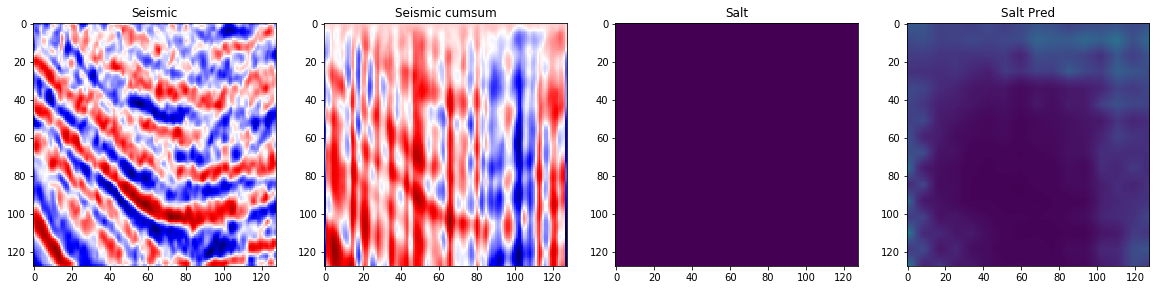

In [22]:
plot_sample(X_train, y_train, preds_train)

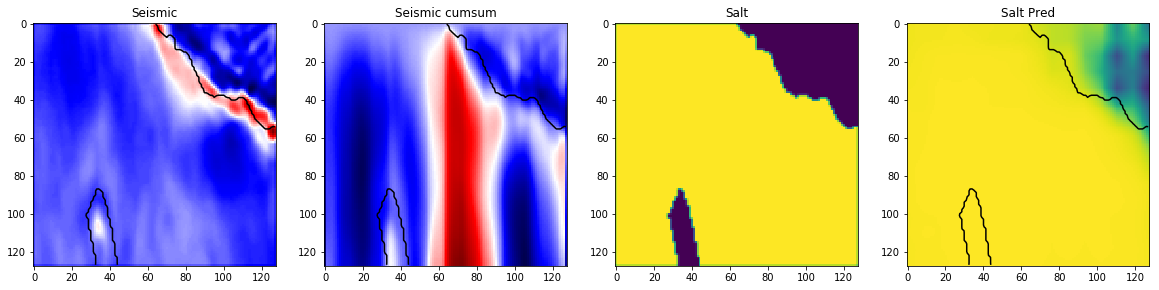

In [23]:
plot_sample(X_valid, y_valid, preds_val)

In [24]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [25]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(y_valid, np.int32(preds_val > t)) for t in tqdm_notebook(thres)]

A Jupyter Widget

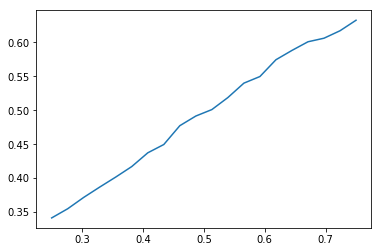

In [26]:
plt.plot(thres, thres_ioc);

In [27]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.75, 0.63275000000000003)

In [28]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {id_[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

A Jupyter Widget

In [29]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('outputs.csv')